In [1]:
from collections import OrderedDict
from time import time

import matplotlib.pyplot as plt 
import numpy as np 
import pandas as pd 
import pymc3 as pm 
import seaborn as sns
import theano as thno 
import theano.tensor as T 
from scipy import integrate 
from scipy.optimize import fmin_powell

print(f'Runnning on PyMC3 v{pm.__version__}')

Runnning on PyMC3 v3.11.2


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

In [28]:
def run_models(df, upper_order = 5):

    models, traces = OrderedDict(), OrderedDict()

    for k in range(1, upper_order + 1):

        nm = f'k{k}'
        fml = create_poly_modelspec(k)

        with pm.Model() as models[nm]:

            print(f'\nRunning: {nm}')
            pm.glm.GLM.from_formula(fml, df, family = pm.glm.families.Binomial())

            traces[nm] = pm.sample(1000, tune = 1000, init = 'adapt_diag', return_inferencedata = True)
            

    return models, traces

In [4]:
def plot_traces(traces, model, retain = 0):

    with model:
        ax = pm.traceplot(
            traces[-retain:],
            lines = tuple([(k, {}, v['mean']) for k, v in pm.summary(traces[-retain:]).iterrows()]),
        )

        for i, mn in enumerate(pm.summary(trace[-retain:])['mean']):
            ax[i, 0].annotate(
                f"{mn:.2f}",
                xy=(mn, 0),
                xycoords="data",
                xytext=(5, 10),
                textcoords="offset points",
                rotation=90,
                va="bottom",
                fontsize="large",
                color="#AA0022",
            )

In [5]:
def create_poly_modelspec(k = 1):
    return (
        "income ~ educ + hours + age " + " ".join([f"+ np.power(age,{j})" for j in range(2, k + 1)])
    ).strip()

In [6]:
raw_data = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None,
    names=[
        "age",
        "workclass",
        "fnlwgt",
        "education-categorical",
        "educ",
        "marital-status",
        "occupation",
        "relationship",
        "race",
        "sex",
        "captial-gain",
        "capital-loss",
        "hours",
        "native-country",
        "income",
    ],
)

In [7]:
raw_data.head()

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [8]:
data = raw_data[~pd.isnull(raw_data['income'])]

In [9]:
data[data['native-country'] == ' United-States'].sample(5)

,age,workclass,fnlwgt,education-categorical,educ,marital-status,occupation,relationship,race,sex,captial-gain,capital-loss,hours,native-country,income
30668,39,Private,176279,Bachelors,13,Divorced,Sales,Not-in-family,White,Female,0,0,40,United-States,<=50K
10260,42,Self-emp-not-inc,212847,HS-grad,9,Never-married,Farming-fishing,Own-child,White,Male,0,0,85,United-States,<=50K
2115,21,State-gov,181761,Some-college,10,Never-married,Tech-support,Own-child,White,Female,0,0,10,United-States,<=50K
21288,33,Private,146440,Some-college,10,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1740,40,United-States,<=50K
24290,72,Federal-gov,94242,Some-college,10,Widowed,Tech-support,Not-in-family,White,Female,0,0,16,United-States,<=50K


In [10]:
income = 1 * (data["income"] == " >50K")

In [11]:
data = data[["age", "educ", "hours"]]

# Scale age by 10, it helps with model convergence.
data["age"] = data["age"] / 10.0
data["age2"] = np.square(data["age"])
data["income"] = income

In [12]:
income.value_counts()

0    24720
1     7841
Name: income, dtype: int64

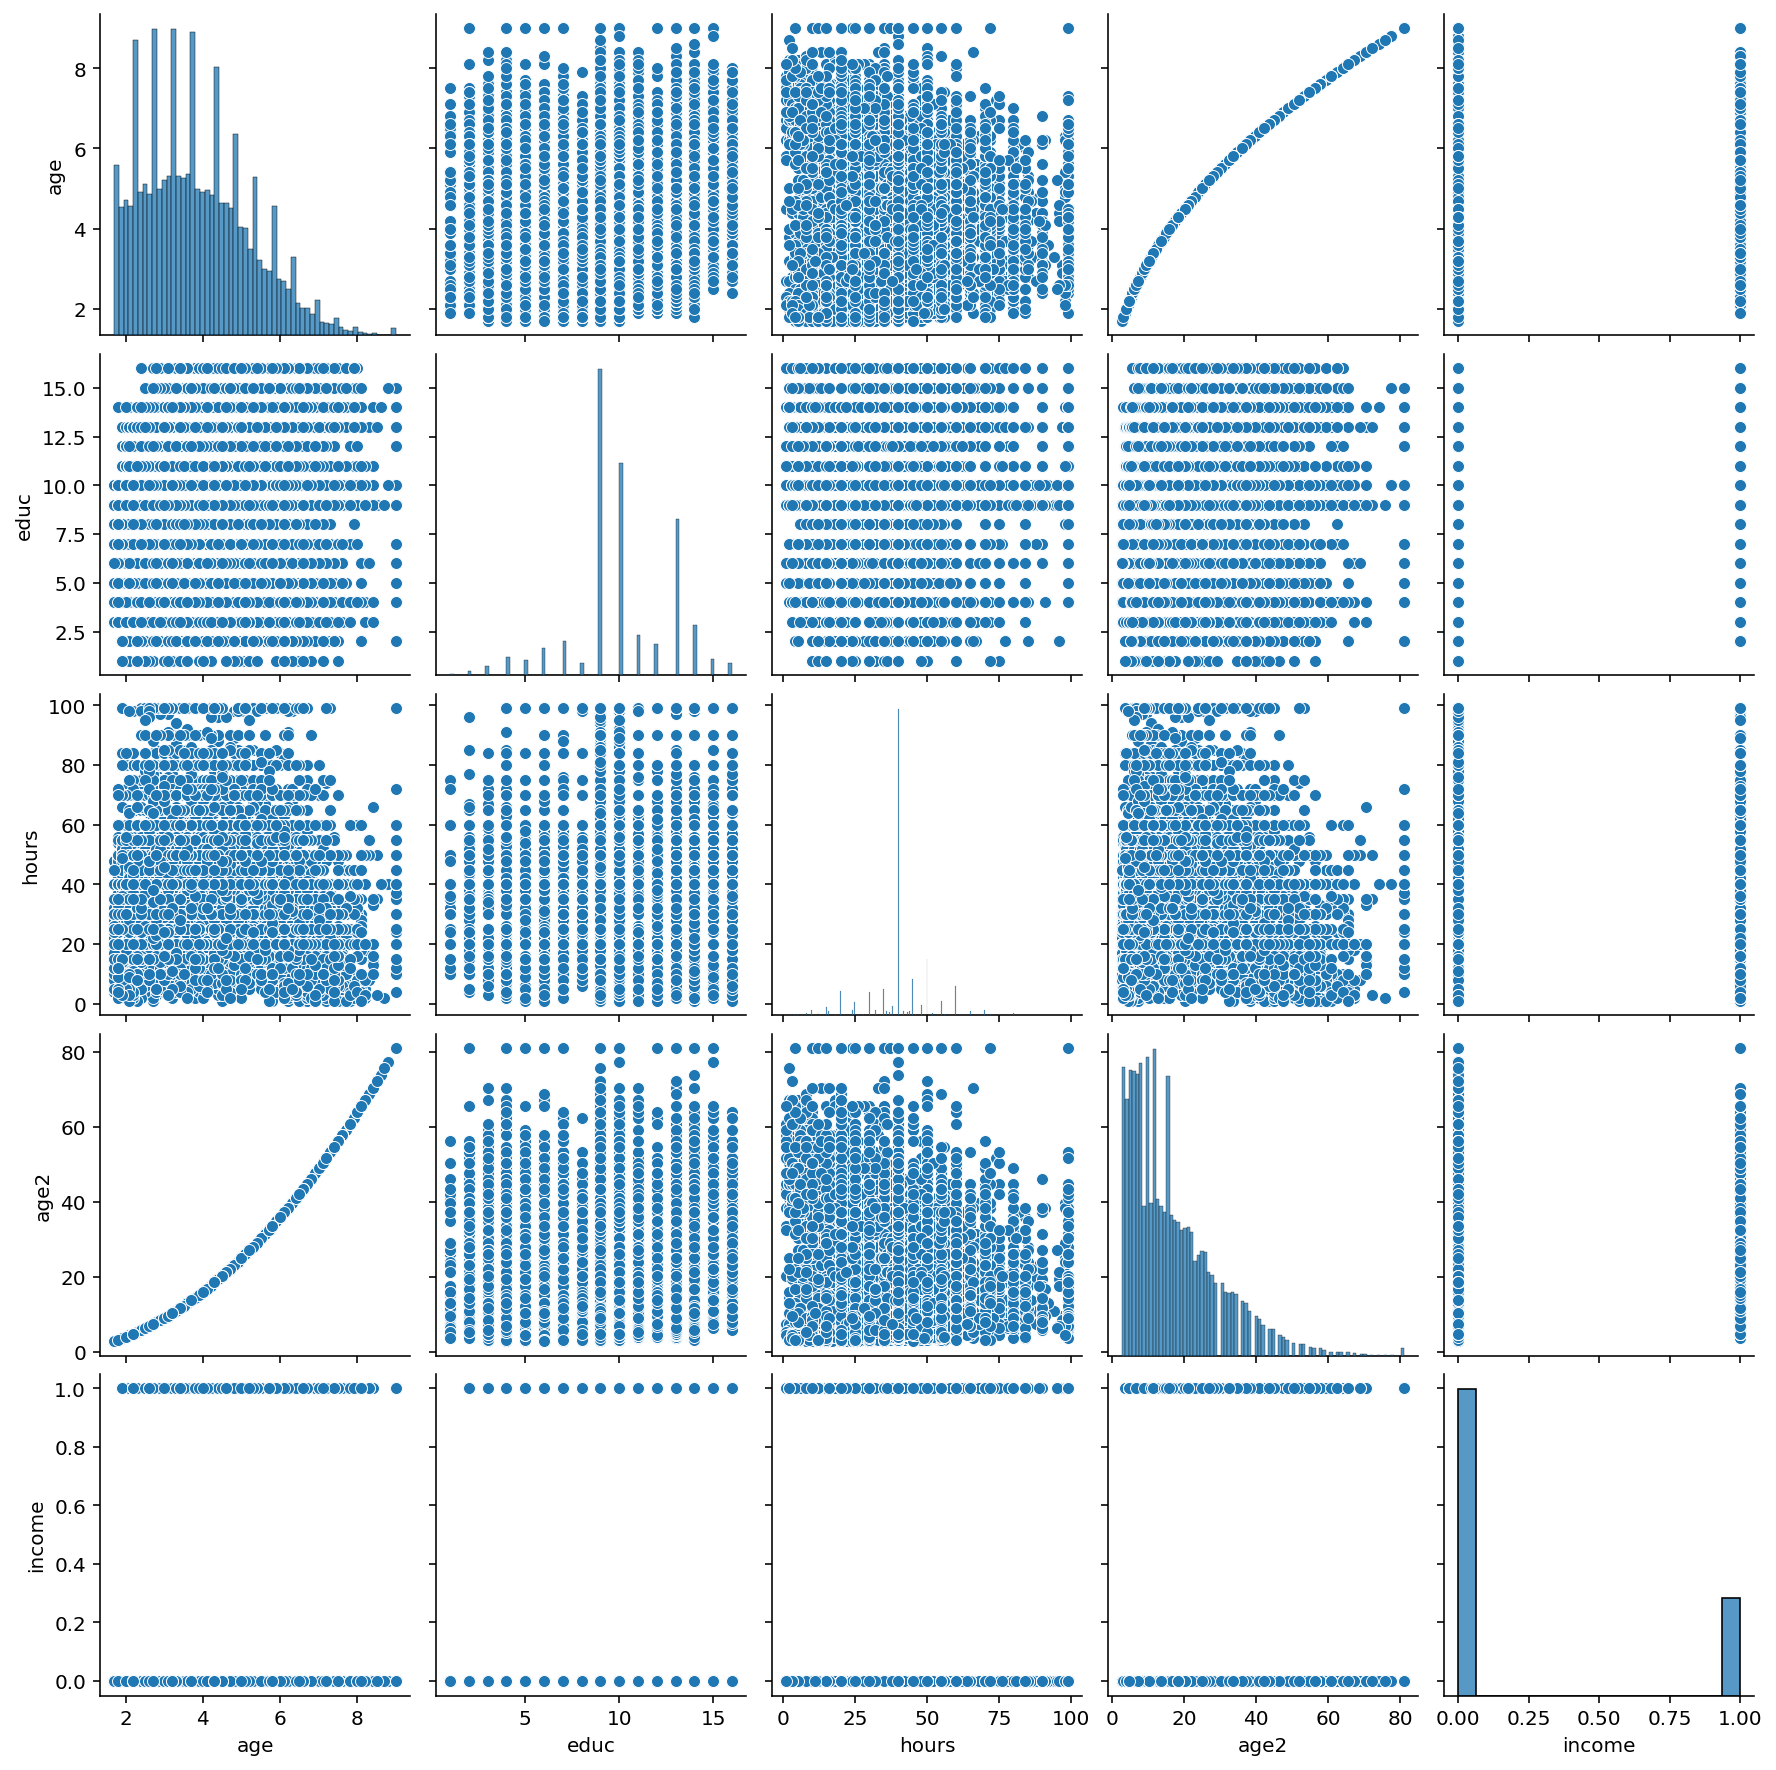

In [13]:
g = sns.pairplot(data)

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """


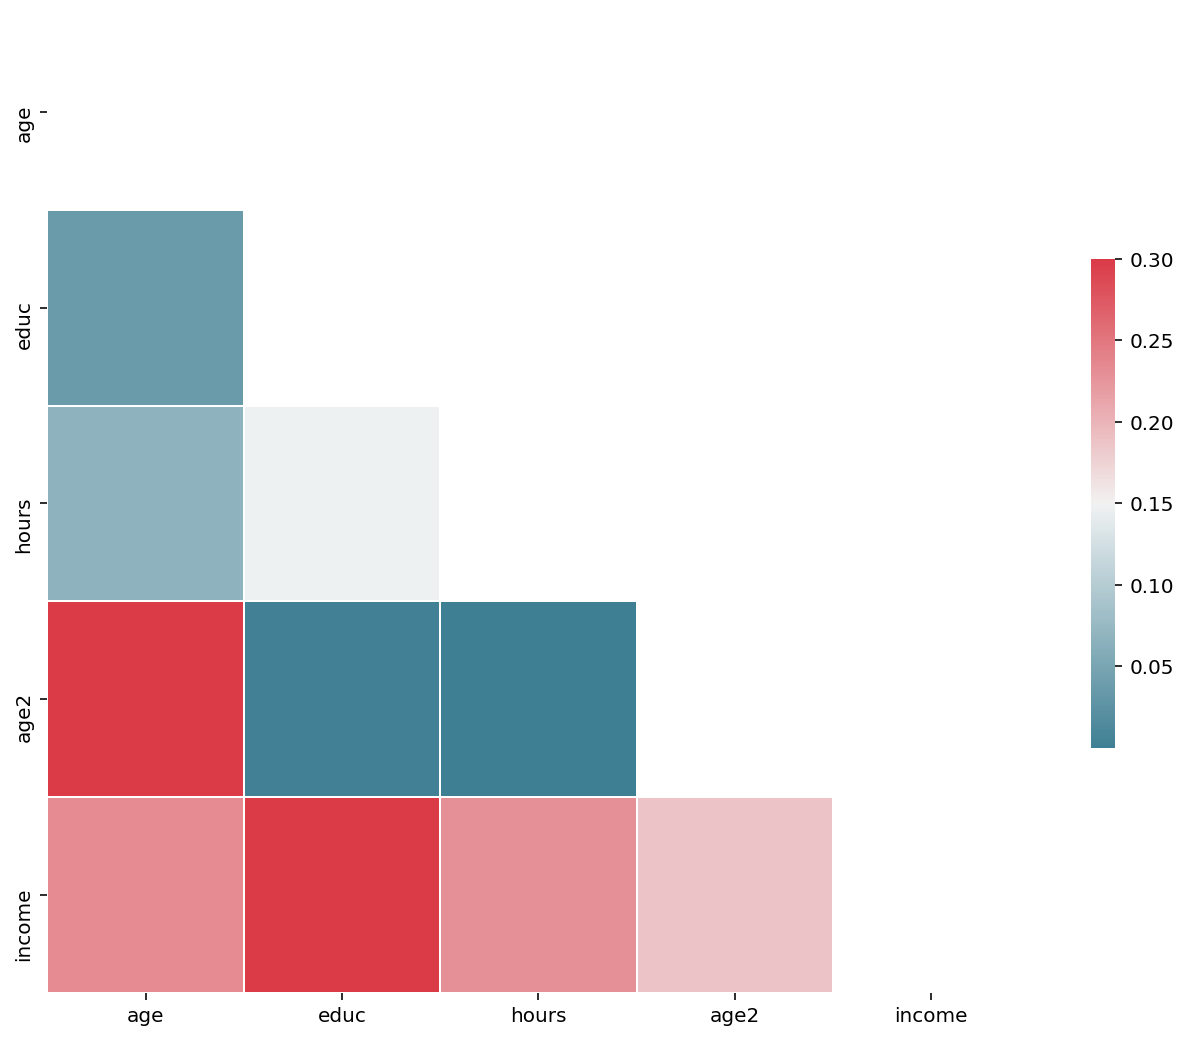

In [14]:
# Compute the correlation matrix
corr = data.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(
    corr,
    mask=mask,
    cmap=cmap,
    vmax=0.3,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
    ax=ax,
);


In [15]:
with pm.Model() as logistic_model:
    pm.glm.GLM.from_formula(
        "income ~ age + age2 + educ + hours", data, family=pm.glm.families.Binomial()
    )
    trace = pm.sample(1000, tune=1000, init="adapt_diag")

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  """
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [hours, educ, age2, age, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 802 seconds.


/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  


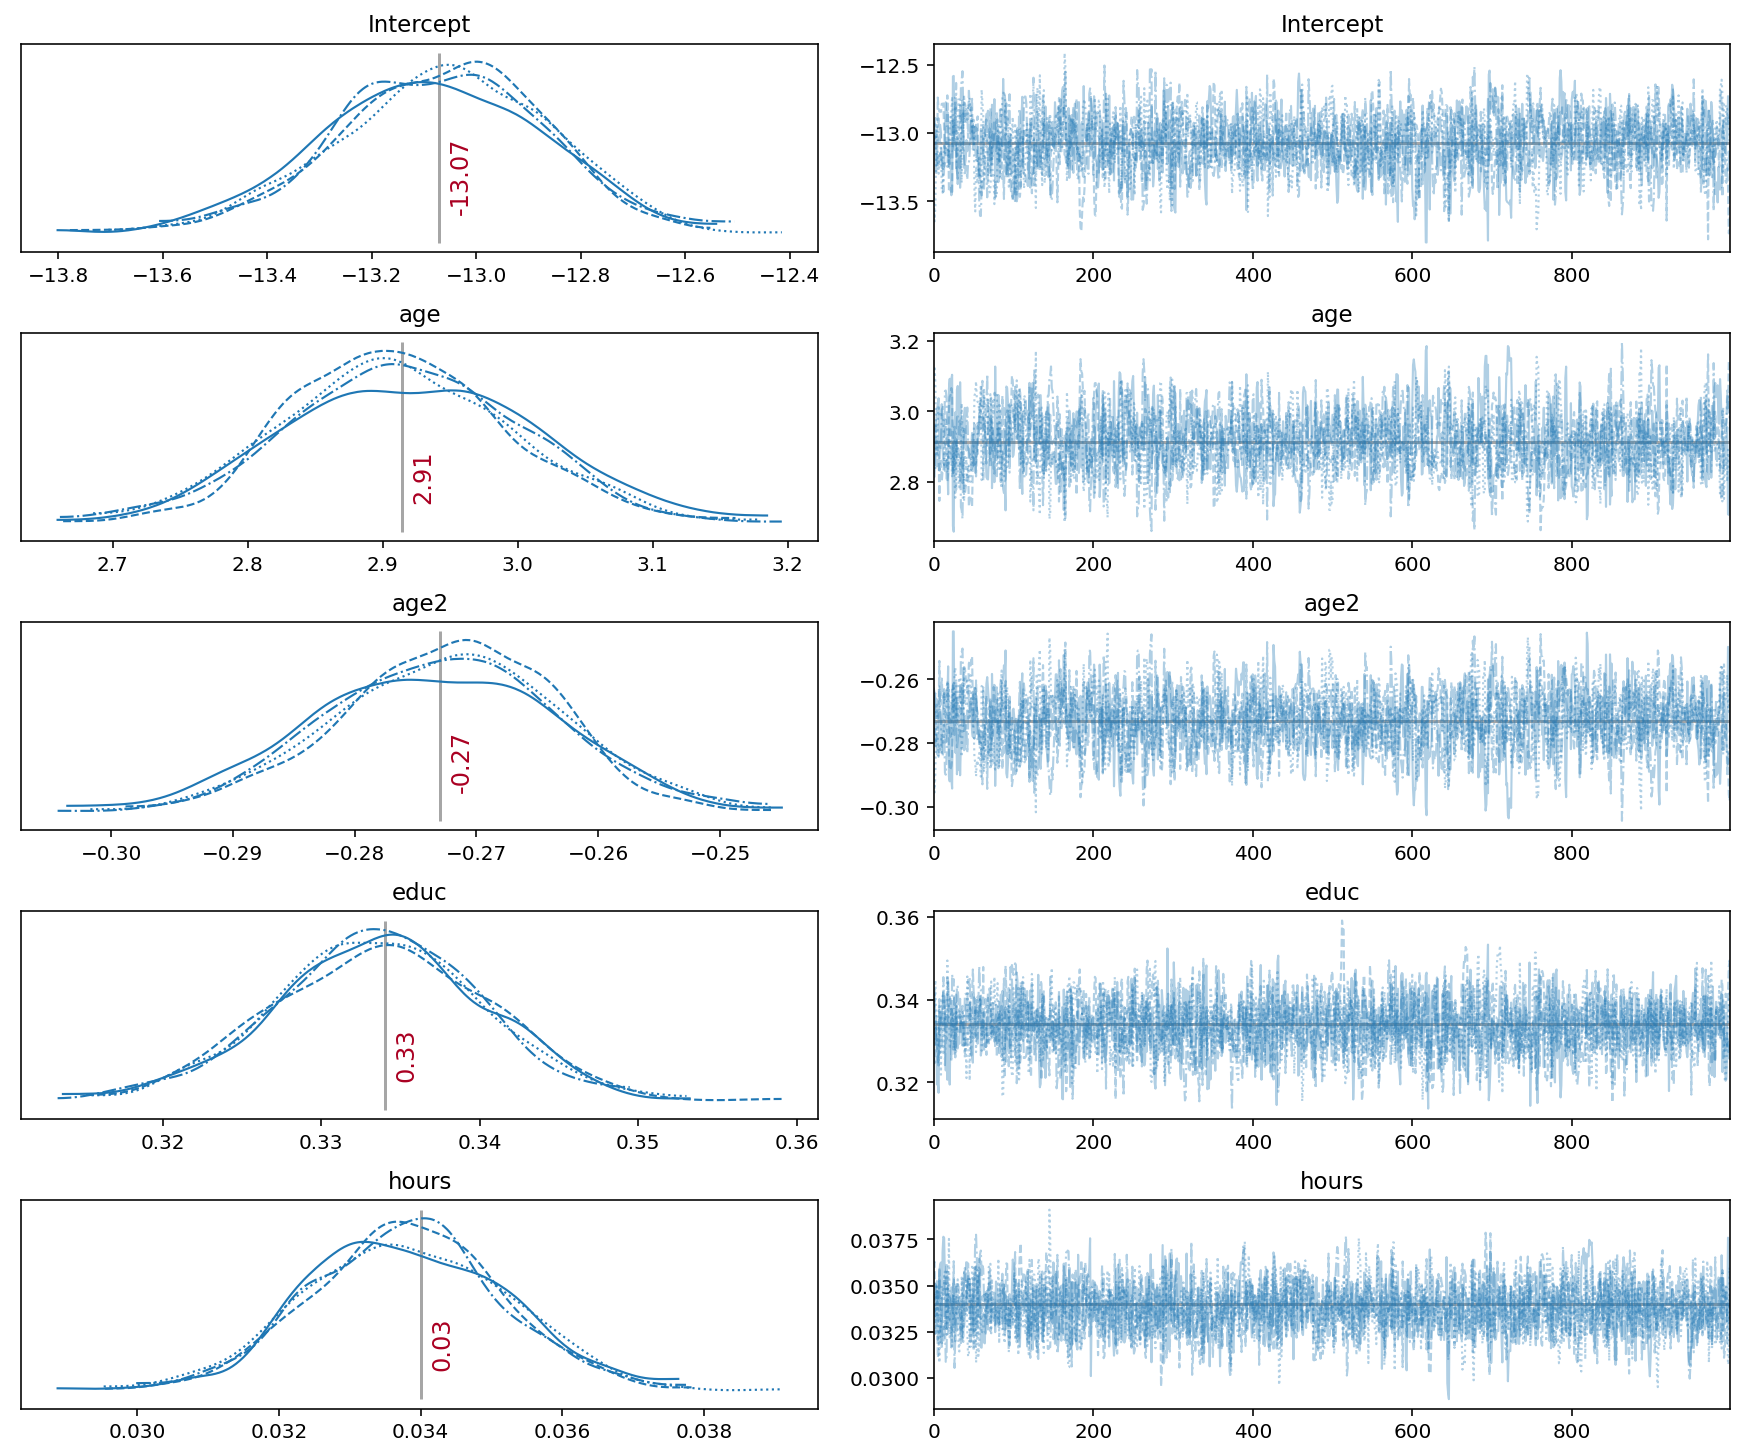

In [16]:
plot_traces(trace, logistic_model);

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<Figure size 648x504 with 0 Axes>

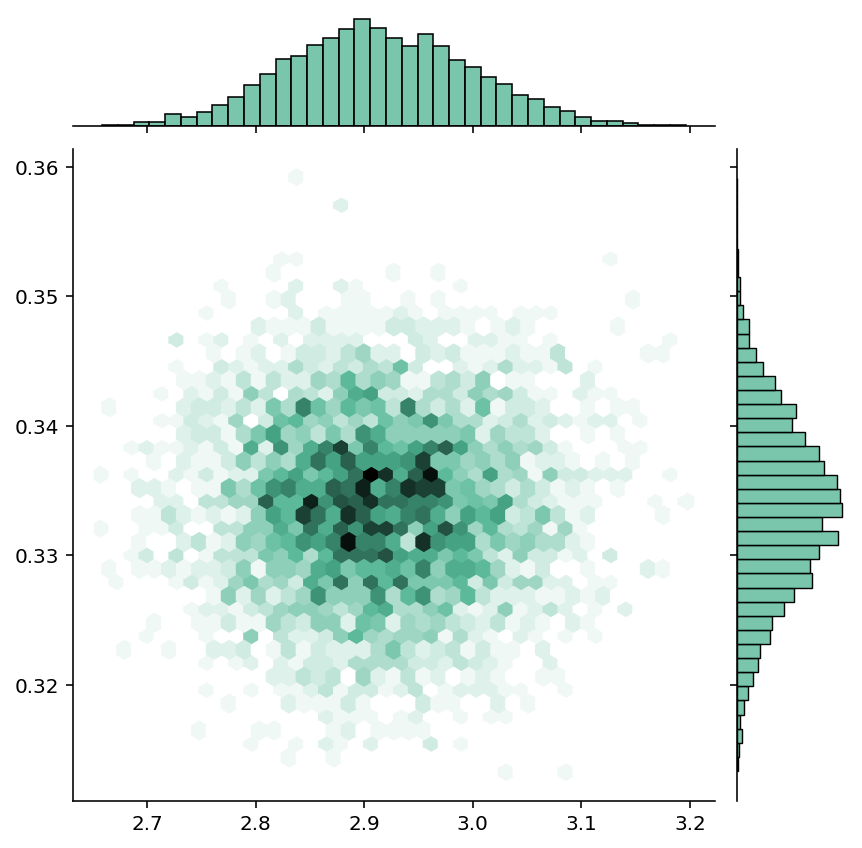

In [18]:
plt.figure(figsize=(9, 7))
sns.jointplot(trace["age"], trace["educ"], kind="hex", color="#4CB391")
plt.xlabel("beta_age")
plt.ylabel("beta_educ");

In [19]:
def lm_full(trace, age, educ, hours):
    shape = np.broadcast(age, educ, hours).shape
    x_norm = np.asarray([np.broadcast_to(x, shape) for x in [age / 10.0, educ, hours]])
    return 1 / (
        1
        + np.exp(
            -(
                trace["Intercept"]
                + trace["age"] * x_norm[0]
                + trace["age2"] * (x_norm[0] ** 2)
                + trace["educ"] * x_norm[1]
                + trace["hours"] * x_norm[2]
            )
        )
    )


# Linear model with hours == 50 and educ == 12
lm = lambda x, samples: lm_full(samples, x, 12.0, 50.0)

# Linear model with hours == 50 and educ == 16
lm2 = lambda x, samples: lm_full(samples, x, 16.0, 50.0)

# Linear model with hours == 50 and educ == 19
lm3 = lambda x, samples: lm_full(samples, x, 19.0, 50.0)

/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/pymc3/plots/posteriorplot.py:62: DeprecationWarning: The `plot_posterior_predictive_glm` function will migrate to Arviz in a future release. 
Keep up to date with `ArviZ <https://arviz-devs.github.io/arviz/>`_ for future updates.
  DeprecationWarning,


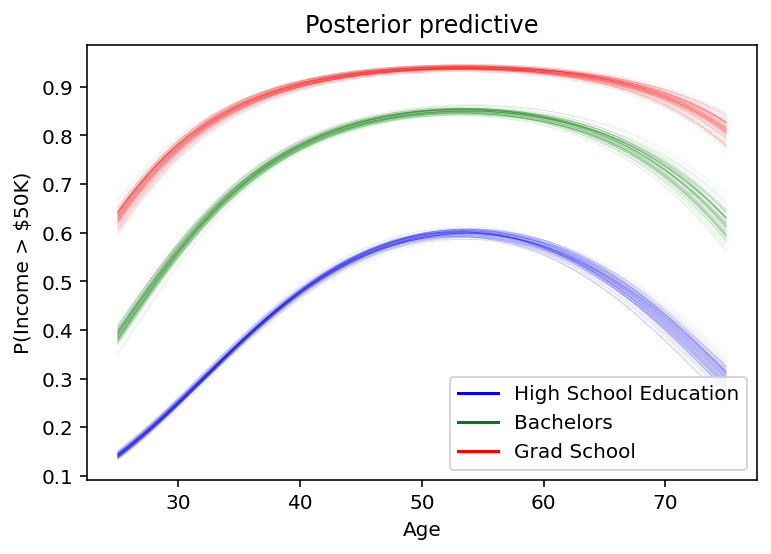

In [20]:
# Plot the posterior predictive distributions of P(income > $50K) vs. age
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(25, 75, 1000), lm=lm, samples=100, color="blue", alpha=0.15
)
pm.plot_posterior_predictive_glm(
    trace,
    eval=np.linspace(25, 75, 1000),
    lm=lm2,
    samples=100,
    color="green",
    alpha=0.15,
)
pm.plot_posterior_predictive_glm(
    trace, eval=np.linspace(25, 75, 1000), lm=lm3, samples=100, color="red", alpha=0.15
)

import matplotlib.lines as mlines

blue_line = mlines.Line2D(["lm"], [], color="b", label="High School Education")
green_line = mlines.Line2D(["lm2"], [], color="g", label="Bachelors")
red_line = mlines.Line2D(["lm3"], [], color="r", label="Grad School")
plt.legend(handles=[blue_line, green_line, red_line], loc="lower right")
plt.ylabel("P(Income > $50K)")
plt.xlabel("Age")
plt.show()

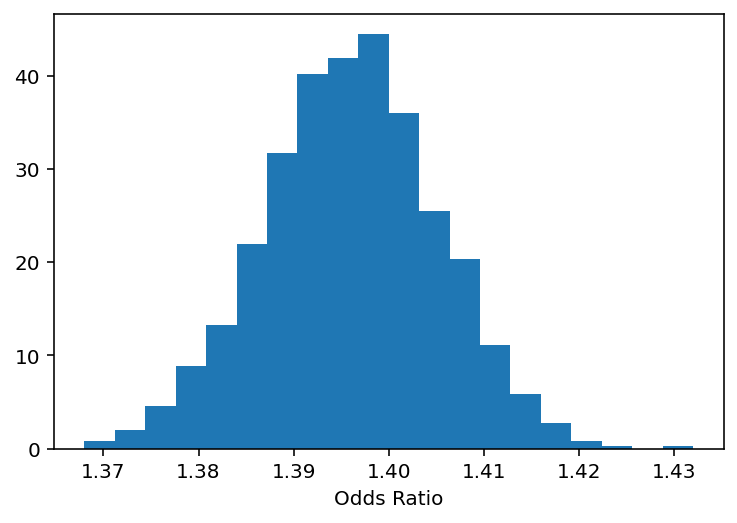

In [21]:
b = trace["educ"]
plt.hist(np.exp(b), bins=20, density=True)
plt.xlabel("Odds Ratio")
plt.show()

In [23]:
lb, ub = np.percentile(b, 2.5), np.percentile(b, 97.5)

print("P({:.3f} < O.R. < {:.3f}) = 0.95".format(np.exp(lb), np.exp(ub)))

P(1.378 < O.R. < 1.414) = 0.95


In [29]:
models_lin, traces_lin = run_models(data, 3)


Running: k1


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [age, hours, educ, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 296 seconds.



Running: k2


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [np.power(age, 2), age, hours, educ, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 856 seconds.



Running: k3


Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [np.power(age, 3), np.power(age, 2), age, hours, educ, Intercept]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2582 seconds.
There were 671 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5726235820334388, but should be close to 0.8. Try to increase the number of tuning steps.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/arviz/stats/stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  "The default method used to estimate the weights for each model,"
/home/ishikawa/anaconda3/envs/pymc/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: The function `compareplot` from PyMC3 is an alias for `plot_compare` from ArviZ. It also applies some kwarg replacements. Nevertheless, please switch to `pymc3.plot_compare` or `arviz.plot_compare`.
  


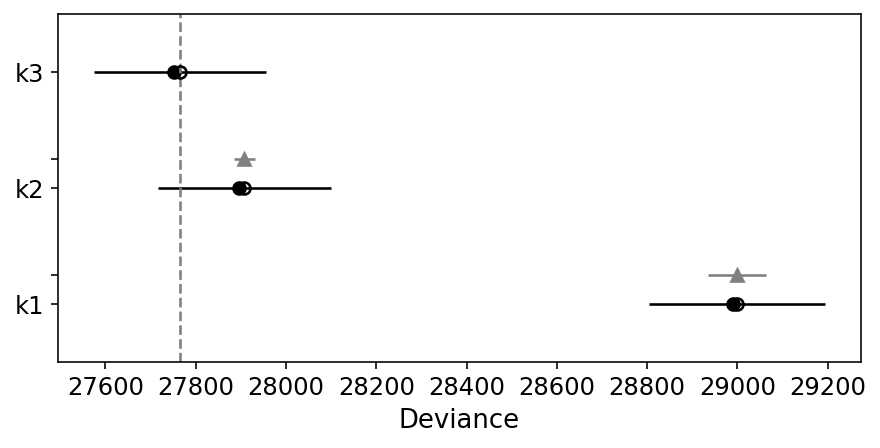

In [30]:
model_trace_dict = dict()
for nm in ["k1", "k2", "k3"]:
    model_trace_dict.update({nm: traces_lin[nm]})

dfwaic = pm.compare(model_trace_dict, ic="WAIC", scale="deviance")
pm.compareplot(dfwaic);